<a href="https://colab.research.google.com/github/tedteske/bounded_lognorm/blob/master/bounded_lognorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

The **bounded lognormal** is a continuous probability distribution derived from the [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). Unlike the normal and lognormal distributions, the  domain of the bounded lognormal has both upper and lower bounds, and it may be symmetrical or skewed, depending on the parameters. It therefore may be a good fit for many natural phenomena, for which the range of possible values is limited, for example adult height and running speed. 

The lognormal probability density function (pdf) is often defined in terms of $\mu_N$ and $\sigma_N$, the mean and standard deviation of some normal distribution $N$:


$$
f_L(x, \mu_N, \sigma_N ) = \frac{1}{x \sigma_N \sqrt{2 \pi}} \times exp(\frac{-(\ln(x) - \mu_N)^2}{2\sigma_N^2}) \tag{1}
$$

If we redefine $f_L$ in terms of mode $m$ and standard deviation $\sigma$ as $f_{L'}$, then the bounded lognormal pdf $f_{BL}$ is the piecewise function:

$$
f_{BL}(x, m, \sigma, upper) =
  \begin{cases}
    f_{L'}(x, m, \sigma)   &  \text{for } x <= m \\
    f_{L'}(upper-x, upper-m, \sigma)   &  \text{for } x > m \\
  \end{cases} \tag{2}
$$

where the second piece is scaled so that $f_{BL}$ is continuous at the mode, and $(lower, upper)$ are the lower and upper bounds of the domain.

### Python Implementation: Class Definition

The bounded lognormal distribution is implemented in Python as an instance of the [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous) class and inherits from it a collection of generic methods.

In [17]:
#
# Author: Ted Teske 2020 
#          

from scipy.stats import rv_continuous, norm
from scipy.special import erf, erfinv
from scipy.integrate import quad, trapz
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
import numpy as np

"""
The following optional imports and plotting settings are for the examples
below, but are not necessary for the class definition itself.
"""
from scipy.stats import truncnorm, lognorm, skew, kurtosis, normaltest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [10, 10/1.6]
"""
End of optional section.
"""


def lognorm_pdf(x, mu_N, sigma_N):
    """
    Log-normal (aka lognormal) probability density function (pdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    # Creates an index of positive elements in x.
    i = np.nonzero(x > 0)

    # Applies lognormal pdf to positive elements. All others evaluate to 0.
    y = np.zeros(len(x))
    y[i] = 1 / (x[i] * sigma_N * np.sqrt(2 * np.pi)) \
        * np.exp(-(np.log(x[i]) - mu_N)**2 / (2 * sigma_N**2))
    return y


def lognorm_cdf(x, mu_N, sigma_N):
    """
    Log-normal cumulative density function (cdf).

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    # Creates an index of positive elements in x.
    i = np.nonzero(x > 0)

    # Applies lognormal cdf to positive elements. All others evaluate to 0.
    y = np.zeros(len(x))
    y[i] = 0.5 + 0.5 * erf((np.log(x[i]) - mu_N) / (np.sqrt(2) * sigma_N))
    return y


def lognorm_ppf(q, mu_N, sigma_N):
    """
    Log-normal percent-point function (ppf), also known as the quantile 
    function, is the inverse of the cdf.

    Parameters
    ----------
    q : {float, list or ndarray of floats}
        quantile(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """
    y = np.exp(mu_N + np.sqrt(2 * sigma_N**2) * erfinv(2 * q - 1))
    return y


def lognorm_params(mode, sigma):
    """
    Given user-defined mode and sigma of a lognormal distribution,
    calculates the mu and sigma of its underlying normal distribution.

    Parameters
    ----------
    mode : float
        mode of lognormal distribution
    sigma : float
        standard deviation of lognormal distribution

    Returns
    -------
    mu_N : float
    sigma_N : float

    References
    ----------
    [1] Adapted from Warren Weckesser's answer to question at
        https://stackoverflow.com/questions/41464753
    """
    # Finds the roots of the polynomial
    # g^4 - g^3 - sigma^2/mode^2
    # where g = e^(variance of the associated Normal distribution)
    p = np.poly1d([1, -1, 0, 0, -(sigma / mode)**2])
    r = p.roots

    # Uses just the real, positive root to calculate sigma_N and mu_N.
    solution = r[(r.imag == 0) & (r.real > 0)].real
    sigma_N = np.sqrt(np.log(solution))
    mu_N = np.log(mode * solution)
    return mu_N, sigma_N


class bounded_lognorm_gen(rv_continuous):
    """
    Subclass of scipy.stats.rv_continuous [1]. This is used to generate a
    domain-bounded lognormal continuous probability distribution, which is 
    fully described by the four parameters: mode, sigma, lower and upper 
    bounds.

    The probability density function (pdf) concatenates two lognormal pdfs
        1. left-of-mode: lognormal pdf with loc at lower bound, and 
        2. right-of-mode: reversed lognormal pdf with loc at upper bound and 
            scaled so that the concatenated pdf is continuous at the mode;
    and scales the concatenated curve so that its integral equals 1.

    Methods
    -------
    same as scipy.stats.rv_continuous [1]

    References
    ----------
    [1] https://docs.scipy.org/doc/scipy/reference/generated
        /scipy.stats.rv_continuous.html
    """
   
    def _argcheck(self, *args):
        """
        Overrides default _argcheck to allow negative parameters. Returns 
        condition array of 1s where arguments are correct and 0s where they 
        are not.
        """
        for arg in args:
            cond = np.isfinite(arg)
        return cond
    
    def _argcheck_final(self, x, mode, sigma, lower, upper, 
                        ignore_checks=False):
        """
        Provides further compatibility checks and conversions for parameters.
        """
        # Converts parameters to scalars, if necessary.
        try:
            mode, sigma, lower, upper = mode[0], sigma[0], lower[0], upper[0]
        except:
            pass
        
        # Checks parameters for compatibility with distribution.
        if not ignore_checks:
            param_conditions = (lower < mode < upper) & (sigma > 0) 
            if not param_conditions:
                error_text = "Requires (lower < mode < upper) and (sigma > 0)"
                raise ValueError(error_text)
        
        # Converts scalar, list, or Series input to array.
        x = np.atleast_1d(x)
        mode = np.atleast_1d(mode)
        return x, mode, sigma, lower, upper
    
    def _pdf(self, x, mode, sigma, lower, upper, ignore_checks=False):
        """
        Probability density function (pdf). Do not call this directly;
        call pdf(), a wrapper for this function, instead.
        """
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(x, mode, sigma, lower, upper, 
                                    ignore_checks)
        x, mode, sigma, lower, upper = args
        
        # Shifts x, lower, upper, and mode so that lower is at 0;
        # allows negative x-values. 
        x, mode, upper = x - lower, mode - lower, upper - lower
        
        # Concatenates left- and right-of-mode pdfs.
        y = self.concat_pdf(x, mode, sigma, upper)        
        return y
      
    def pdf(self, x, mode, sigma, lower, upper):
        """
        Probability density function (pdf).

        Parameters
        ----------
        x : {float, list, ndarray of floats}
            x-value(s)
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float
            lower bound of the domain (x-values)
        upper : float
            upper bound of the domain (x-values)

        Returns
        -------
        relative likelihood [2] of x : ndarray of float(s)

        Note
        ----
        This is a wrapper for _pdf().
        
        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Probability_density_function
        """
        return self._pdf(x, mode, sigma, lower, upper)
    
    def _cdf(self, x, mode, sigma, lower, upper, ignore_checks=False):
        """
        Cumulative density function (cdf). Do not call this directly;
        call cdf(), a wrapper for this function, instead.
        """       
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(x, mode, sigma, lower, upper,
                                    ignore_checks)
        x, mode, sigma, lower, upper = args
               
        # Shifts x, lower, upper, and mode so that lower is at 0;
        # allows negative x-values. 
        x, mode, upper = x - lower, mode - lower, upper - lower
        
        # Concatenates left- and right-of-mode cdfs.
        y = self.concat_cdf(x, mode, sigma, upper) 
        return y
    
    def cdf(self, x, mode, sigma, lower, upper):
        """
        Cumulative density function (cdf).

        Parameters
        ----------
        x : {float, list, ndarray of floats}
            x-value(s)
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float
            lower bound of the domain (x-values)
        upper : float
            upper bound of the domain (x-values)

        Returns
        -------
        probability(s) that random variable <= x : ndarray of float(s)

        Note
        ----
        This is a wrapper for _cdf().
        
        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Cumulative_distribution_function
        """
        return self._cdf(x, mode, sigma, lower, upper)
        
    def _ppf(self, q, mode, sigma, lower, upper, ignore_checks=False):
        """
        Percent-point function (ppf). Do not call this directly;
        call ppf(), a wrapper for this function, instead.
        """       
        # Checks parameters for compatibility with distribution and converts.
        args = self._argcheck_final(q, mode, sigma, lower, upper,
                                    ignore_checks)
        q, mode, sigma, lower, upper = args
               
        # Shifts lower, upper, and mode so that lower is at 0;
        # allows negative x-values. 
        mode, upper = mode - lower, upper - lower
        
        # Concatenates left- and right-of-mode cdfs and adds back lower.
        y = self.concat_ppf(q, mode, sigma, upper) + lower
        return y 
    
    def ppf(self, q, mode, sigma, lower, upper):
        """
        Percent-point function (ppf), also known as the quantile function, is
        the inverse of the cdf. 

        Parameters
        ----------
        q : {float, list, ndarray of floats}
            quantile(s), lower tail probability
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float
            lower bound of the domain (x-values)
        upper : float
            upper bound of the domain (x-values)

        Returns
        -------
        x-value(s), such that P(X <= x) is q : ndarray of float(s) [2]

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Quantile_function
        """        
        return self._ppf(q, mode, sigma, lower, upper)
    
    def rvs(self, mode, sigma, lower, upper, size=1, random_state=None):
        """
        Generates random variate(s) using inverse transform sampling [1].

        Parameters
        ----------
        mode : float
            x at the point of maximum frequency [2]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float
            lower bound of the domain (x-values)
        upper : float
            upper bound of the domain (x-values)
        size : int
            number of random variates to generate
        random_state : None, int, or numpy.random.RandomState
            not used; for backward compatibility only

        Returns
        -------
        ndarray of float(s) 
       
        References
        ----------
        [1] https://en.wikipedia.org/wiki/Inverse_transform_sampling
        [2] https://en.wikipedia.org/wiki/Mode_(statistics)
        """
        uniform_rands = np.random.uniform(size=int(size))
        return self._ppf(uniform_rands, mode, sigma, lower, upper)
  
    def _stats(self, mode, sigma, lower, upper, moments='mv'):
        """
        Calculates population mean('m'), variance('v'), skew('s'), 
        and/or kurtosis('k').

        Parameters
        ----------
        mode : float
            x at the point of maximum frequency
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float
            lower bound of the domain (x-values)
        upper : float
            upper bound of the domain (x-values)
        moments : str, optional
            composed of letters ['mvsk'] defining which moments to compute:
            'm' = mean,
            'v' = variance,
            's' = (Fisher's) skew,
            'k' = (Fisher's) kurtosis.
            (default is 'mv')

        Returns
        -------
        ndarray
        
        References
        ----------
        [1] Raiford, Theodore E. “Skewness of Combined Distributions.” 
            Journal of the American Statistical Association, 
            vol. 37, no. 219, 1942, pp. 391–393. 
            JSTOR, www.jstor.org/stable/2279009. 
            Accessed 18 Sept. 2020.
        [2] Wang, Yibing, et. al. "Speed Modeling and Travel Time Estimation 
            Based on Truncated Normal and Lognormal Distributions." 
            Transportation Research Record, No. 2315, 2012, pp. 66-72. 
            ResearchGate, www.researchgate.net/publication/272774439.
            Accessed 18 Sept. 2020.
        [3] Ford and McLaren. "METHODS FOR OBTAINING DISTRIBUTIONS OF
            URANIUM OCCURRENCE FROM ESTIMATES OF GEOLOCJ:C FEATURES." Union 
            Carbide Corporation for the Department of Energy, 1980. 
            U.S. Department of Energy Office of Scientific and Technical 
            Information, https://www.osti.gov/servlets/purl/5121047. 
            Accessed 18 Sept. 2020.
        """
        def partial_moment(mu_N, sigma_N, k, n=1):
            """
            Conditional probability formula used here adapted from [2] p. 71 
            and [3] p. 76:
            
            part = (norm.cdf(zb - n * sigma_N) - norm.cdf(za - n * sigma_N)) 
            part /= (norm.cdf(zb) - norm.cdf(za))
            
            where za and zb are cutoff points expressed in standard deviations
            
            but if  we are only concerned with right cutoff:

            za  = (np.log(0) - mu_N) / sigma_N 
                = (-np.inf - mu_N) / sigma_N 
                = -np.inf
            
            and norm.cdf(-np.inf) == 0

            then
            part = norm.cdf(z - n * sigma_N) / norm.cdf(z)
            """
            # lognormal moment generating function
            moment = np.exp((n * mu_N) + (0.5 * n**2 * sigma_N**2)) 
            
            # adjustement for portion below cutoff
            z = (np.log(k) - mu_N) / sigma_N  # cutoff in standard deviations
            part = norm.cdf(z - n * sigma_N) / norm.cdf(z)
            return moment * part

        def partial_mean(mu_N, sigma_N, k):   
            return partial_moment(mu_N, sigma_N, k, 1)

        def partial_var(mu_N, sigma_N, k):
            mom1 = partial_moment(mu_N, sigma_N, k, 1)
            mom2 = partial_moment(mu_N, sigma_N, k, 2)
            return mom2 - mom1**2

        def partial_skew(mu_N, sigma_N, k):              
            mom1 = partial_moment(mu_N, sigma_N, k, 1)
            mom2 = partial_moment(mu_N, sigma_N, k, 2)
            mom3 = partial_moment(mu_N, sigma_N, k, 3)
            mu2 = mom2 - mom1**2
            mu3 = mom3 - mom1 * (mom1**2 + 3 * mu2)
            return mu3 / mu2**1.5  

        def partial_kurt(mu_N, sigma_N, k):
            mom1 = partial_moment(mu_N, sigma_N, k, 1)
            mom2 = partial_moment(mu_N, sigma_N, k, 2)
            mom3 = partial_moment(mu_N, sigma_N, k, 3)
            mom4 = partial_moment(mu_N, sigma_N, k, 4)
            mu2 = mom2 - mom1**2
            mu3 = mom3 - mom1 *  (mom1**2 + 3 * mu2)
            mu4 = mom4 - mom1 * ((mom1**2 + 6 * mu2) * mom1 + 4 * mu3)
            return mu4 / mu2**2 

        params_a = lognorm_params(mode - lower, sigma)
        params_b = lognorm_params(upper - mode, sigma)
        w = self._cdf(mode, mode, sigma, lower, upper)

        # mean from weighted partial means
        mu_a = partial_mean(*params_a, mode - lower) + lower
        mu_b = upper - partial_mean(*params_b, upper - mode)
        mu = w * mu_a  + (1 - w) * mu_b

        # variance from weighted partial variances
        mu2_a = partial_var(*params_a, mode - lower)
        mu2_b = partial_var(*params_b, upper - mode)
        d_a, d_b = mu_a - mu, mu_b - mu
        mu2 =        w * (mu2_a + d_a**2)
        mu2 += (1 - w) * (mu2_b + d_b**2)

        # skew from weighted partial skews, adapted from [1]
        g1_a = partial_skew(*params_a, mode - lower) 
        g1_b = -partial_skew(*params_b, upper - mode)
        g1 =        w * (g1_a * mu2_a**1.5 + d_a * (3 * mu2_a + d_a**2))
        g1 += (1 - w) * (g1_b * mu2_b**1.5 + d_b * (3 * mu2_b + d_b**2))
        g1 /= mu2**1.5

        # kurtosis from weighted partial kurtoses
        g2_a = partial_kurt(*params_a, mode - lower) 
        g2_b = partial_kurt(*params_b, upper - mode) 
        g2 = w * (g2_a * mu2_a**2 
                  + d_a * (d_a * (6 * mu2_a + d_a**2) 
                  + 4 * g1_a * mu2_a**1.5))
        g2 += (1 - w) * (g2_b * mu2_b**2 
                         + d_b * (d_b * (6 * mu2_b + d_b**2) 
                         + 4 * g1_b * mu2_b**1.5))
        g2 /= mu2**2 
        g2 -= 3
        
        return mu, mu2, g1, g2
       
    def concat_pdf(self, x, mode, sigma, upper):
        """
        Concatenates left- and right-of-mode pdfs.
        """
        # Left of mode.
        mu_N_left, sigma_N_left = lognorm_params(mode, sigma)
        x_left = np.append(x[x <= mode], mode, axis=0)
        y_left = lognorm_pdf(x_left, mu_N_left, sigma_N_left)

        # Right of mode.
        mu_N_right, sigma_N_right = lognorm_params(upper - mode, sigma)
        x_right = np.append(x[x > mode], mode, axis=0)
        y_right = lognorm_pdf(upper - x_right, mu_N_right, sigma_N_right)
        
        # Scales right side so that left and right sides continuous at mode.
        y_right = y_right * y_left[-1] / y_right[-1] 
        
        # Concatenates left and right sides, dropping the extra modes 
        # appended above.
        y = np.append(y_left[:-1], y_right[:-1], axis=0)
        
        # Normalizes concatenated pdf to area == 1.
        scale = self._cdf(mode, mode, sigma, 0, upper, ignore_checks=True)
        scale /= lognorm_cdf(mode, mu_N_left, sigma_N_left)
        y = y * scale
        return y

    def concat_cdf(self, x, mode, sigma, upper):
        """
        Concatenates left- and right-of-mode cdfs
        """
        # Appends upper for use in scaling below.
        x = np.append(x, np.atleast_1d(upper), axis=0)
        
        # Left of mode.
        mu_N_left, sigma_N_left = lognorm_params(mode, sigma)
        x_left = np.append(x[x <= mode], mode, axis=0)
        y_left = lognorm_cdf(x_left, mu_N_left, sigma_N_left)
        slope_left = lognorm_pdf(mode, mu_N_left, sigma_N_left)
        
        # Right of mode.
        mu_N_right, sigma_N_right = lognorm_params(upper - mode, sigma)
        x_right = np.append(x[x > mode], mode, axis=0)
        y_right = lognorm_cdf(upper - x_right, mu_N_right, sigma_N_right)
        slope_right = lognorm_pdf(upper - mode, mu_N_right, sigma_N_right)

        # Transforms right side so that curve is continuous at mode and
        # monotonic increasing.    
        y_right = -y_right * slope_left / slope_right  # flips, matches slope
        y_right = y_right + y_left[-1] - y_right[-1]  # matches levels
        
        # Concatenates left and right sides, dropping the extra modes 
        # appended above.
        y = np.append(y_left[:-1], y_right[:-1], axis=0)
        
        # Normalizes concatenated cdf to max == 1, dropping the extra upper
        # appended above.
        scale = 1 / y[-1] 
        return y[:-1] * scale 

    def concat_ppf(self, q, mode, sigma, upper):
        """
        Concatenates left- and right-of-mode ppfs
        """       
        # Left of mode.
        mu_N_left, sigma_N_left = lognorm_params(mode, sigma)
        qmode_left = self._cdf(mode, mode, sigma, 0, upper)
        qmode_left2 = lognorm_cdf(mode, mu_N_left, sigma_N_left)
        q_left = q[q <= qmode_left] * qmode_left2/qmode_left
        y_left = lognorm_ppf(q_left, mu_N_left, sigma_N_left)
        
        # Right of mode.
        mu_N_right, sigma_N_right = lognorm_params(upper - mode, sigma)
        qmode_right = self._cdf(upper - mode, upper - mode, sigma, 0, upper)
        qmode_right2 = lognorm_cdf(upper - mode, mu_N_right, sigma_N_right)
        q_right = (1 - q[q > qmode_left]) * qmode_right2/qmode_right
        y_right = lognorm_ppf(q_right, mu_N_right, sigma_N_right)
        
        # Transforms right side so that curve is continuous at mode and
        # monotonic increasing.
        y_right = -y_right + upper    
        
        # Concatenates left and right sides.
        y = np.append(y_left, y_right, axis=0)
        return y
    
    def fit(self, data, xdata=None, MLE=False, fit_cdf=False,
            fmode=None, fsigma=None, flower=None, fupper=None,
            gmode=None, gsigma=None, glower=None, gupper=None):
        """
        Fits random variates (if xdata is None) or histogram to a pdf by 
        estimating bounded_lognorm parameters.

        Parameters
        ----------
        data : {list of floats, ndarray of floats}
            random variates or relative likelihoods (if xdata is not None)
        xdata : {None, list of floats, ndarray of floats}, of length len(data)
            histogram bins
        MLE : boolean 
            If True, use maximum likelihood estimation.
            If False, use least squares estimation (default).
        fit_cdf : boolean
            If True, fit data to cdf.
            If False, fit data to pdf.
        fmode, fsigma, flower, fupper : {None, float} 
            parameters held to fixed constants
        gmode, gsigma, glower, gupper : {None, float} 
            initial guesses, overridden by fixed parameters

        Returns
        -------
        shapes : ndarray 
            shape parameters (mode, sigma, lower, upper)
        popt : ndarray
            estimated (i.e. non-fixed) parameters
        pcov : {ndarray, None}
            estimated covariance matrix of popt or None if MLE=True 

        Note
        ----
        "The diagonals [of pcov] provide the variance of the parameter 
        estimate. To compute one standard deviation errors on the parameters 
        use perr = np.sqrt(np.diag(pcov))." [1]

        References
        ----------
        [1] https://docs.scipy.org/doc/scipy/reference/generated
            /scipy.optimize.curve_fit.html
        """
        # If xdata is not None, then assumes data are relative frequencies and
        # xdata are bins. If xdata is None, assumes data are random variates 
        # and converts to a histogram or ecdf.
        if xdata is None:
            sample_size = len(data)
            if fit_cdf:  # converts data to ecdf
                xdata, counts = np.unique(data, return_counts=True)
                ydata = np.cumsum(counts, dtype=np.double) / sample_size
            else:  # fit pdf; converts data to histogram
                ydata, xdata = np.histogram(data, density=True, 
                                            bins=sample_size)
                # Set xdata to center of bin edges.
                xdata = np.mean([xdata[:-1], xdata[1:]], axis=0)
        else:
            ydata = data
    
        # Collects fixed parameters in fparams.
        fparams = np.array([fmode, fsigma, flower, fupper])
        fmask = (fparams != np.array(None))
        
        # Collects guessed parameters in gparams and applies default guesses 
        # where none supplied by user.
        gparams = np.array([gmode, gsigma, glower, gupper])
        gdefs = np.array([np.median(data), data.std(), 
                         xdata.min(), xdata.max()])  # default guesses
        gmask = (gparams != np.array(None))
        gparams[~gmask] = gdefs[~gmask] 
        gparams = np.array(gparams[~fmask], dtype='float64') 

        # Provides a container for shape parameters.
        shapes = np.ones(4)
        
        # Wraps the cdf or pdf function to hold fixed parameters constant.
        def curve_to_be_fit(x, *args):
            shapes[~fmask] = args
            shapes[fmask] = fparams[fmask]
            if fit_cdf:
                return self._cdf(x, *shapes, ignore_checks=True)
            else: 
                return self._pdf(x, *shapes, ignore_checks=True)
        
        # This is the objective function to be minimized by MLE below.
        # It returns the negative log-likelihood of pdf_to_be_fit.
        def minimize_this(params):         
            sd = params[-1]
            params = params[:-1]
            y_hat = curve_to_be_fit(xdata, *params)
            return -np.sum(norm.logpdf(ydata, loc=y_hat, scale=sd))
        
        # Why are these ignores necessary?
        with np.errstate(invalid='ignore', divide='ignore'):
            if MLE:  # maximum likelihood estimation
                gparams = np.append(gparams, 1)  # add one for sd
                results = minimize(minimize_this, gparams, 
                                   method='Nelder-Mead')
                popt = results.x[:-1]
                shapes[~fmask] = popt
                shapes[fmask] = fparams[fmask]
                return shapes, popt, None
            else:  # non-linear least squares estimation
                popt, pcov = curve_fit(curve_to_be_fit, xdata, ydata, 
                                       p0=gparams)
                shapes[~fmask] = popt
                shapes[fmask] = fparams[fmask]
                return shapes, popt, pcov
                    
bounded_lognorm = bounded_lognorm_gen(name='bounded_lognorm', 
                                      shapes='mode, sigma, lower, upper')


### Derivation

#### From $f_L$ to $f_{L'}$

**[Note: The formulas below do not render well in GitHub. If you are viewing this in GitHub, click on the "Open in Colab" link at the top of this page to see them rendered correctly.]**

If $\mu_N$ and $\sigma_N^2$ are the mean and variance of some normal distribution $N$, then the mode $m$ and variance $\sigma^2$ of the associated lognormal distribution are 

$$
\begin{align}
       m & = exp(\mu_N - \sigma_N^2) \tag{3} \\\
\sigma^2 & = (exp(\sigma_N^2)-1) \times exp(2\mu_N + \sigma_N ^2) \tag{4}
\end{align}
$$

Letting $g = exp(\sigma_N^2)$ and substituting into equation (4):

$$
\begin{align} 
\sigma^2 & = (g-1) \times exp(2\mu_N + \sigma_N ^2) \\\
         & = (g-1) \times exp(2\mu_N) \times exp(\sigma_N^2) \\\ 
         & = (g-1) \times exp(2\mu_N) \times g \\\
         & = g(g-1) \times exp(2\mu_N)  \tag{5}
\end{align}
$$ 

Rearrangeing equation (3) to solve for $\mu_N$ and plugging into the second expression above:

$$
\begin{align} 
\mu_N & = \ln(m) + \sigma_N^2 \tag{6} \\\ \\\
exp(2\mu_N) & = exp(2(\ln(m)+\sigma_N^2)) \\\
            & = exp(2\ln(m)+2\sigma_N^2) \\\
            & = exp(2\ln(m))+ exp(2\sigma_N^2) \\\
            & = exp(\ln(m))^2+ exp(\sigma_N^2)^2 \\\
            & = m^2g^2 
\end{align}
$$ 

Substituting $m^2g^2$ into equation (5) and rearranging as a quartic equation:

$$
\begin{align} 
\sigma^2 & = g(g-1) \times m^2g^2  \\\
        & = g^3(g-1) \times m^2  \\\
        & = (g^4 - g^3) \times m^2 \\\ \\\
      0 & = g^4 - g^3 -  \sigma^2/m^2 \tag{5}
\end{align}
$$ 

Rearrangeing equation (3) to solve for $\sigma_N$ in terms of $g_r$, the unique positive real root of equation (5):

$$
\sigma_N = \sqrt{\ln(g_r)} \tag{6}
$$

Solving for $\mu_N$ in terms of $g_r$:

$$
\mu_N = \ln(m \times g_r) \tag{7}
$$

Equations (6) and (7) provide the arguments to $f_{L}$.

_References_: 
1. https://en.wikipedia.org/wiki/Log-normal_distribution
2. https://math.stackexchange.com/questions/2003529/derive-mode-of-lognornormal-distribution
3. https://stackoverflow.com/questions/41464753

#### From $f_{L'}$ to $f_{BL}$ in Python

In this section we'll make use of the following functions:
* lognorm_pdf() corresponding to equation (1) above and
* lognorm_params() corresponding to equations (3) through (7) above.

Let's start with an example lognormal pdf with $m = 1$ and $\sigma = 1$. 

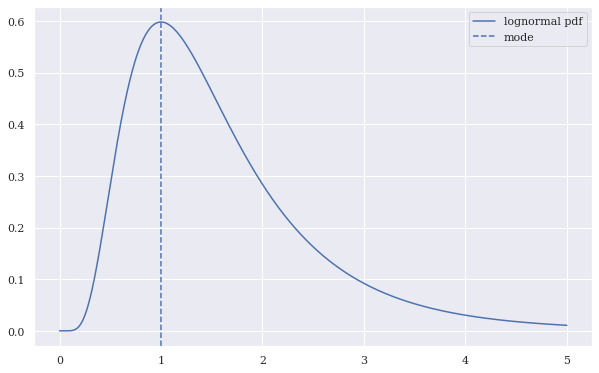

In [18]:
mode, sigma = 1, 1
lower, upper = 0, 5
mu_N, sigma_N = lognorm_params(mode, sigma)

x = np.linspace(lower, upper, 1000)
y = lognorm_pdf(x, mu_N, sigma_N)

sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Plot just the left-of-mode portion.

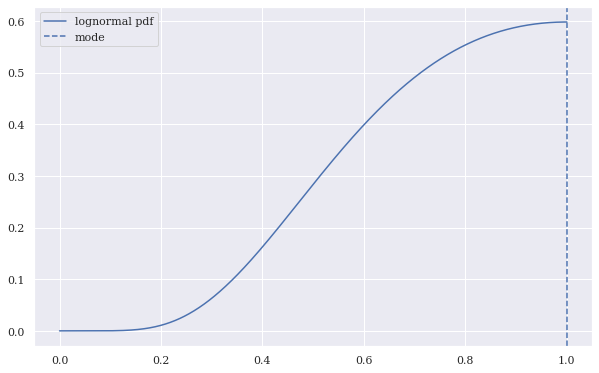

In [19]:
mode, sigma = 1, 1
mu_N, sigma_N = lognorm_params(mode, sigma)

x = np.linspace(lower, mode, 1000)
y = lognorm_pdf(x, mu_N, sigma_N)

sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Assign, for example, an upper bound of 5. Plot the left-of-mode portion of a lognormal pdf with $m = upper - mode$ and reversed $x$ values. This is the right-of-mode portion of a new bounded lognormal pdf.

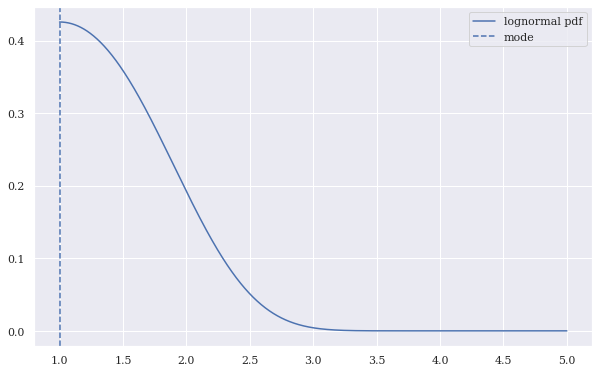

In [20]:
mode, sigma = 1, 1
lower, upper = 0, 5
mu_N, sigma_N = lognorm_params(upper - mode, sigma)

x = np.linspace(mode, upper, 1000)
y = lognorm_pdf(upper - x, mu_N, sigma_N)
sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Concatenate the left-of-mode and right-of-mode curves above. Notice that they are discontinuous at the mode.

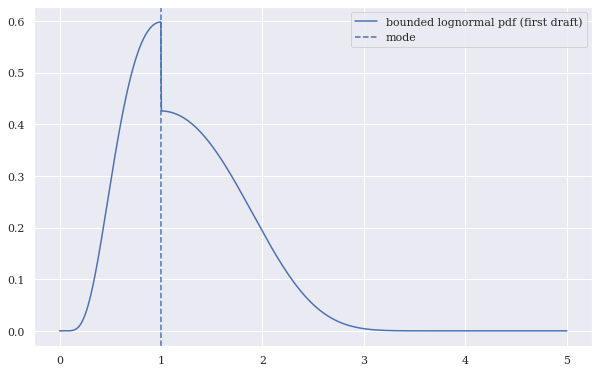

In [21]:
mu_N, sigma_N = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
y_left = lognorm_pdf(x_left, mu_N, sigma_N)

mu_N, sigma_N = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
y_right = lognorm_pdf(upper - x_right, mu_N, sigma_N)

x = np.concatenate([x_left, x_right])
y = np.concatenate([y_left, y_right])
sns.lineplot(x, y, label="bounded lognormal pdf (first draft)")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Scale right side so that left and right sides are continuous at the mode.

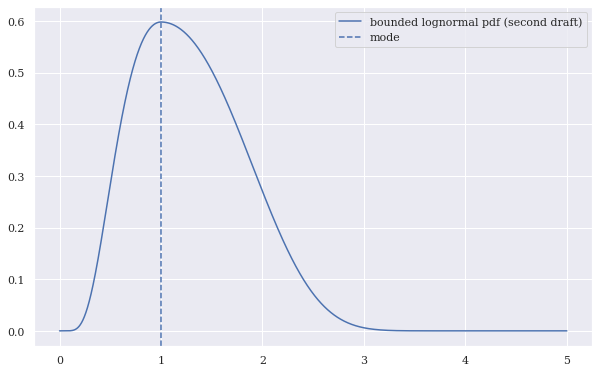

In [22]:
mu_N, sigma_N = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
x_left = np.append(x_left, [mode], axis=0)
y_left = lognorm_pdf(x_left, mu_N, sigma_N)

mu_N, sigma_N = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
x_right = np.append(x_right, [mode], axis=0)
y_right = lognorm_pdf(upper - x_right, mu_N, sigma_N)

right_scale =  y_left[-1] / y_right[-1]

y_right = y_right * right_scale

x = np.concatenate([x_left[:-1], x_right[:-1]])
y = np.concatenate([y_left[:-1], y_right[:-1]])
sns.lineplot(x, y, label="bounded lognormal pdf (second draft)")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

What remains in order to use this as a probability density function is to scale the entire curve, so the area under the curve = 1.

### Example Usage

#### Function Plots and Random Number Generation

Probability density functions (pdf) with various modes, sigmas, and boundaries.

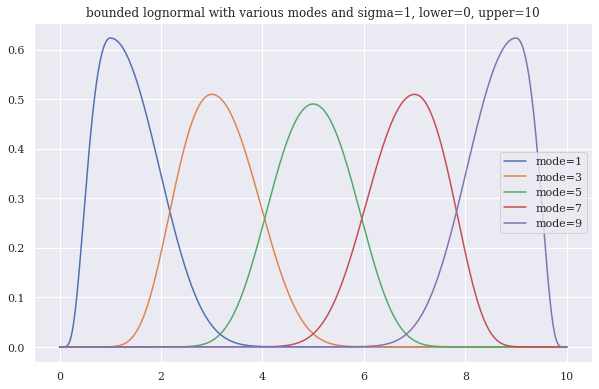

In [23]:
modes = [1, 3, 5, 7, 9]
sigma = 1
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)

for mode in modes:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='mode=' + str(mode))
plt.title('bounded lognormal with various modes and sigma=' + str(sigma) +
          ', lower=' + str(lower) +
          ', upper=' + str(upper))
plt.show()

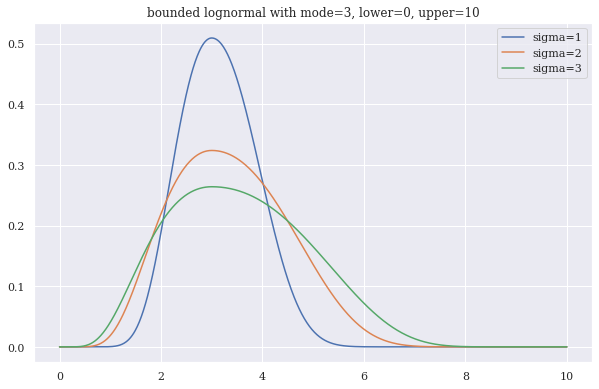

In [24]:
mode = 3
sigmas = [1, 2, 3]
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)

for sigma in sigmas:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='sigma=' + str(sigma))
plt.title('bounded lognormal with mode=' + str(mode) +
          ', lower=' + str(lower) +
          ', upper=' + str(upper))
plt.show()

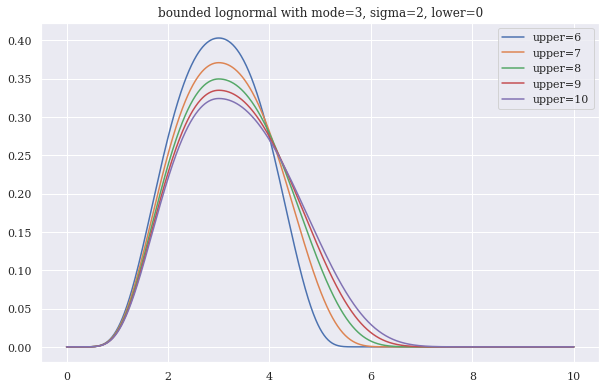

In [76]:
mode, sigma, lower = 3, 2, 0
uppers = [6, 7, 8, 9, 10]
x = np.linspace(lower, uppers[-1], 1000)

for upper in uppers:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='upper=' + str(upper))
plt.title('bounded lognormal with mode=' + str(mode) +
          ', sigma=' + str(sigma) +
          ', lower=' + str(lower))
plt.show()

Probability density function (pdf) with 95% confidence interval

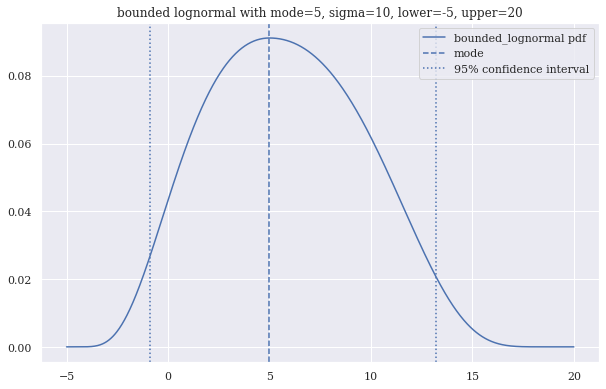

In [25]:
mode, sigma = 5, 10
lower, upper = -5, 20

x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y, label='bounded_lognormal pdf')
plt.axvline(mode, ymin=0, linestyle='dashed', label='mode')

interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
plt.axvline(interval[0], ymin=0, linestyle='dotted', 
            label='95% confidence interval')
plt.axvline(interval[1], ymin=0, linestyle='dotted')
title = ('bounded lognormal with mode=' + str(mode) +
          ', sigma=' + str(sigma) +
          ', lower=' + str(lower) +
          ', upper=' + str(upper))
plt.title(title)
plt.legend()
plt.show()

In [26]:
%timeit -r 3 bounded_lognorm.pdf(x, mode, sigma, lower, upper)

1000 loops, best of 3: 803 µs per loop


Cumulative distribution function (cdf)

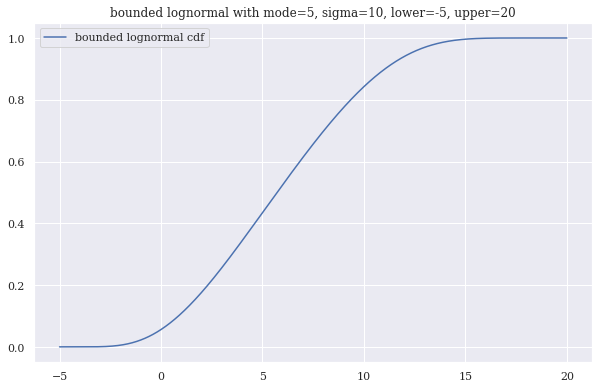

In [27]:
x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.cdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y, label='bounded lognormal cdf')
plt.title(title)
plt.show()

Percent point function (ppf), the inverse of the cdf.

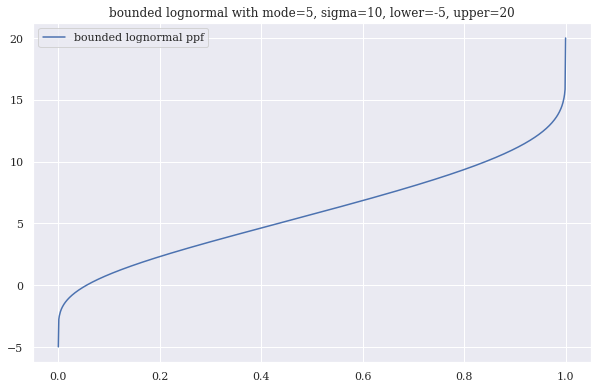

In [28]:
x = np.linspace(0, 1, 1000)
y = bounded_lognorm.ppf(x, mode, sigma, lower, upper)
sns.lineplot(x, y, label='bounded lognormal ppf')
plt.title(title)
plt.show()

In [29]:
%timeit -r 3 bounded_lognorm.ppf(x, mode, sigma, lower, upper)

1000 loops, best of 3: 1.19 ms per loop


Print 10 random numbers from this distribution.

In [30]:
bounded_lognorm.rvs(mode, sigma, lower, upper, size=10)

array([ 0.09940766,  5.36899553,  8.63363162, 10.97615081,  7.66410282,
       12.66839813,  9.43150049,  6.91836701,  9.00410965,  9.60823211])

Plot a histogram of 10,000 random numbers from this distribution.

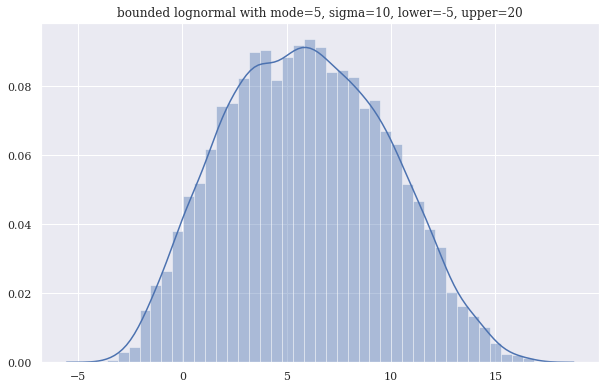

In [31]:
y = bounded_lognorm.rvs(mode, sigma, lower, upper, size=10000)
sns.distplot(y)
plt.title(title)
plt.show()

#### Summary Statistics

Median

In [32]:
bounded_lognorm.median(mode, sigma, lower, upper)

array([5.72045173])

Mean

In [33]:
bounded_lognorm.mean(mode, sigma, lower, upper)

5.849409133600801

Standard deviation

In [34]:
bounded_lognorm.std(mode, sigma, lower, upper)

3.8116950031747745

Note that this is *not* the same as $\sigma$, due to the proximity of the lower and upper domain boundaries. See the section below comparing the bounded lognormal and normal distributions for an illustration.

Moments

In [35]:
mean, var, skew, kurt = bounded_lognorm.stats(mode, sigma, lower, upper, 
                                              moments='mvsk')
mean, var, skew, kurt 

(array(5.84940913), array(14.5290188), array(0.13655252), array(-0.66320023))

#### Fitting Curves to Univariate and Bivariate Data

See for reference
* https://www.mathworks.com/help/stats/examples/fitting-a-univariate-distribution-using-cumulative-probabilities.html
* https://math.stackexchange.com/questions/2365267/pdf-vs-cdf-fitting
* http://www.mathwave.com/articles/distribution-fitting-graphs.html

Create some noisy random numbers and fit them to a bounded_lognorm.pdf using non-linear least squares.

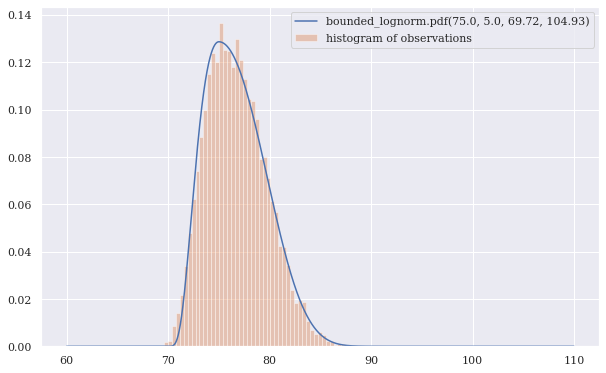

In [36]:
sample_size = 10000
ydata = bounded_lognorm.rvs(75, 5, 70, 100, size=sample_size)
ydata += 1 * np.random.normal(0, 1, size=sample_size) # add some noise

# Here, fmode=75 and fsigma=5 mean fix the params mode and sigma to 75 and 5,
# respectively, and estimate the other params.
shapes, popt, pcov = bounded_lognorm.fit(ydata, fmode=75, fsigma=5, 
                                         MLE=False, fit_cdf=True)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf' + str(shapes_rounded)) 

xdata = np.linspace(60, 110, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(ydata, kde=False, norm_hist=True, 
             label="histogram of observations")

plt.legend(loc='upper right')
plt.show()

Covariance matrix of estimated parameters, in this case `lower` and `upper`

In [37]:
pcov

array([[ 1.21791515e-05, -8.46472033e-05],
       [-8.46472033e-05,  1.36598371e-03]])

Standard deviation of estimated parameters, in this case `lower` and `upper`

In [38]:
np.sqrt(np.diag(pcov))

array([0.00348986, 0.03695922])

Fit the same random numbers to a bounded_lognorm.pdf using maximum likelihood estimation.

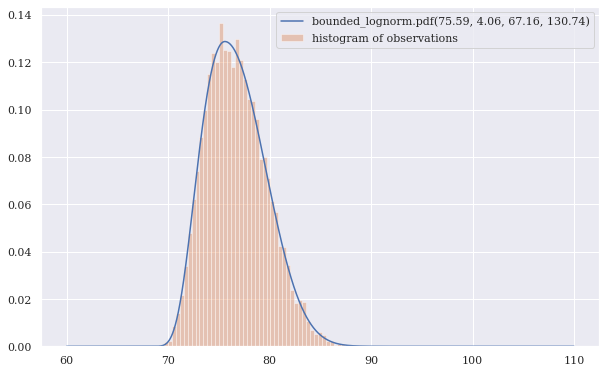

In [39]:
# Here, gmode=75 and gsigma=5 mean provide initial guesses of 75 and 5 to  
# mode and sigma, respectively. All parameters here are estimated.
shapes, popt, pcov = bounded_lognorm.fit(ydata, gmode=75, gsigma=5, 
                                         MLE=True, fit_cdf=True)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf' + str(shapes_rounded)) 

xdata = np.linspace(60, 110, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(ydata, kde=False, norm_hist=True, 
             label="histogram of observations")

plt.legend(loc='upper right')
plt.show()

Fit bivariate data to a pdf.

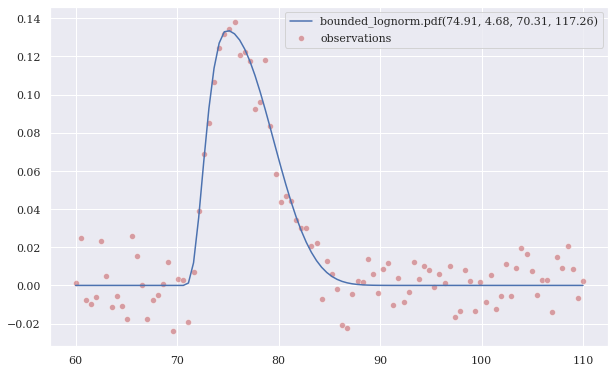

In [40]:
sample_size = 100
xdata = np.linspace(60, 110, sample_size)
ydata = bounded_lognorm.pdf(xdata, 75, 5, 70, 100)
ydata += 0.01 * np.random.normal(0, 1, size=sample_size) # add some noise

shapes, popt, pcov = bounded_lognorm.fit(ydata, xdata, fit_cdf=False,
                                         gmode=75, gsigma=5)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf' + str(shapes_rounded)) 

sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.scatterplot(xdata, ydata, alpha=0.5, color='r', label='observations')

plt.legend()
plt.show()

### Compared to Other Distributions

#### The Normal Distribution

Let's first define a function that plots a normal pdf and a symmetrical bounded lognormal pdf for comparison. Include the 95% confidence interval for each. A symmetrical bounded lognormal distribution is one in which the mode is the midpoint between the lower and upper boundaries. Take as a paramater `spread` or distance from the mode to the domain boundaries.

In [41]:
def compare_to_standard_N(spread):
    mode, sigma = 0, 1
    lower = mode - spread
    upper = mode + spread

    x = np.linspace(-4, 4, 1000)
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x,y, label='bounded lognormal pdf')
    interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dashed', 
                label='bounded lognormal 95% conf. interval')
    plt.axvline(interval[1], ymin=0, linestyle='dashed')

    y = norm.pdf(x, loc=mode, scale=sigma)
    sns.lineplot(x,y, label='standard normal pdf')
    interval2 = norm.interval(0.95, loc=mode, scale=sigma)
    plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
                label='standard normal 95% conf interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

    plt.legend()
    plt.show()

As the upper and lower bounds move away from the mode, the bounded lognormal pdf appears to better approximate the normal pdf.

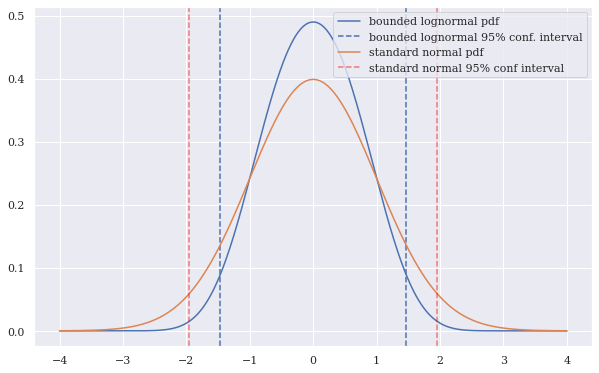

In [42]:
compare_to_standard_N(5)

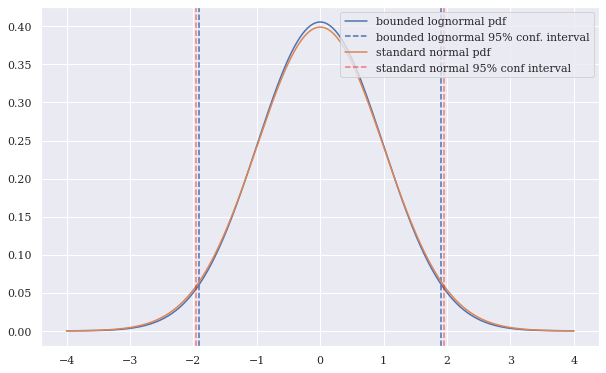

In [43]:
compare_to_standard_N(50)

So that at a large enough spread, the two pdfs are visually indistinguishable.

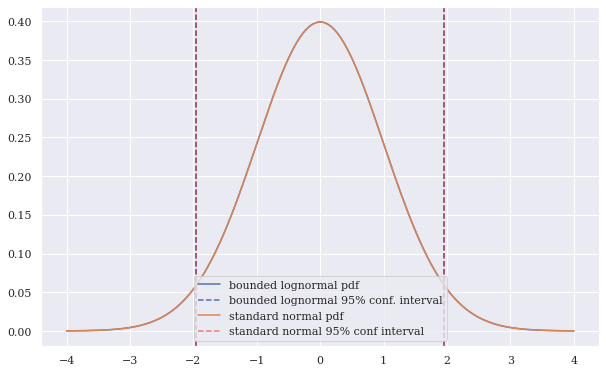

In [44]:
compare_to_standard_N(5000)

Moreover, we cannot reject the null hypothesis that the `spread=5000` sample comes from a normal distribution.

In [45]:
alpha = 0.05
spread = 5000
mode, sigma = 0, 1
lower, upper = mode - spread, mode + spread
wide_BL_sample = bounded_lognorm.rvs(mode, sigma, lower, upper, size=100000)
_, pvalue = normaltest(wide_BL_sample)
print("pvalue = {:.3}".format(pvalue))
if pvalue < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

pvalue = 0.684
The null hypothesis cannot be rejected


And as `spread` increases, excess kurtosis declines toward 0.

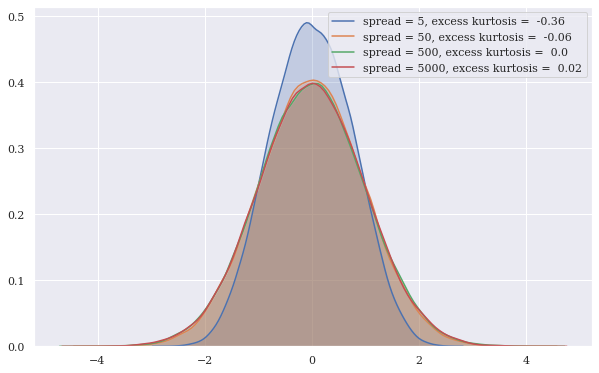

In [46]:
mode, sigma = 0, 1
spreads = [5, 50, 500, 5000]
for spread in spreads:
    lower, upper = mode - spread, mode + spread
    y = bounded_lognorm.rvs(mode, sigma, lower, upper, size=100000)
    k = kurtosis(y, fisher=True)
    label = 'spread = ' + str(spread)
    label += ', excess kurtosis =  ' + str(round(k,2))
    sns.kdeplot(y, label=label, shade=True)
plt.legend()
plt.show()

#### The Lognormal Distribution

In [47]:
def compare_to_LN(spread, log_xscale=False):
    mode, sigma = 1, 1
    lower = 0
    upper = mode + spread
    x = np.linspace(0, 5, 1000)
    
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='bounded lognormal pdf')
    interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dashed', 
                label='bounded lognormal 95% conf. interval')
    plt.axvline(interval[1], ymin=0, linestyle='dashed')

    mu_N, sigma_N = lognorm_params(mode, sigma)
    y = lognorm.pdf(x, loc=0, scale=np.exp(mu_N), s=sigma_N)
    sns.lineplot(x, y, label='lognormal pdf')
    interval2 = lognorm.interval(0.95, loc=0, scale=np.exp(mu_N), s=sigma_N)
    plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
                label='lonormal 95% conf interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

    if log_xscale:
        plt.xscale('log')
    plt.legend()
    plt.show()

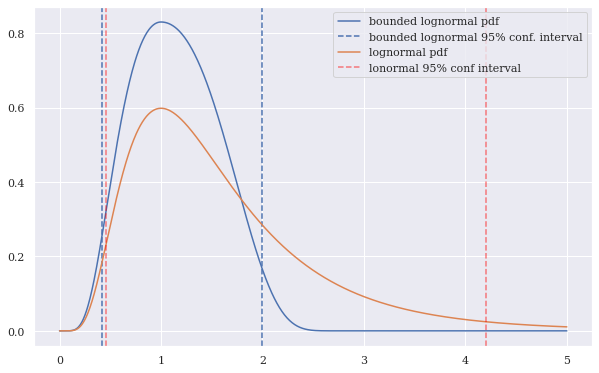

In [48]:
compare_to_LN(2)

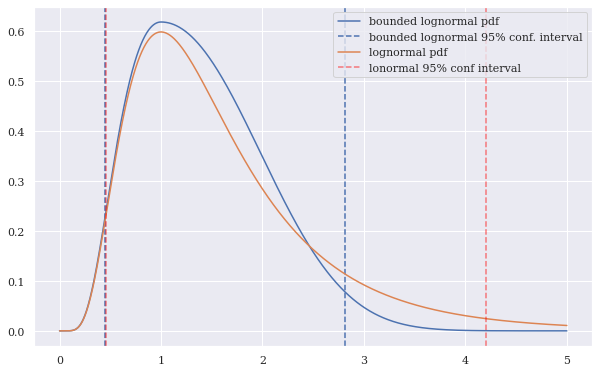

In [49]:
compare_to_LN(10)

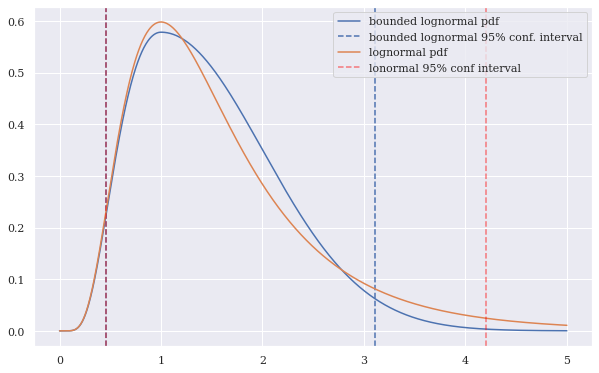

In [50]:
compare_to_LN(1000)

#### The Truncated Normal Distribution

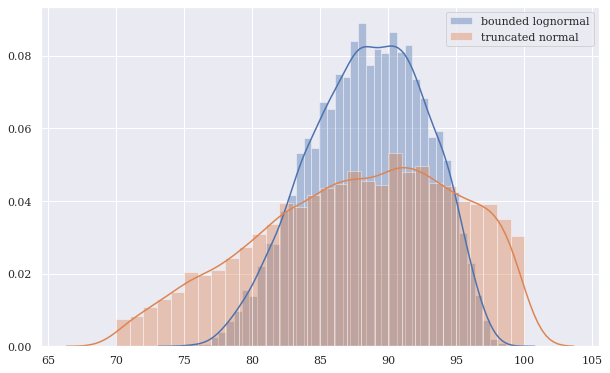

In [51]:
mode, sigma = 90, 10
lower, upper = 70, 100
sample_size = 10000

sns.distplot(bounded_lognorm.rvs(mode=mode, sigma=sigma, 
                                 lower=lower, upper=upper, size=sample_size),
             label='bounded lognormal')
sns.distplot(truncnorm.rvs((lower - mode) / sigma,  
                           (upper - mode) / sigma,
                           mode, sigma, size=sample_size),
             label='truncated normal')
plt.legend()
plt.show()

### Applications

#### What are the fastest possible 100m sprint times?

Let's first load data from the 2004-2016 Olympics. See [here](https://deepblue.lib.umich.edu/data/concern/data_sets/cr56n184r?locale=en) for details on this dataset.

In [52]:
url = 'https://deepblue.lib.umich.edu/data/downloads/qn59q4716?locale=en'
sprint_data = pd.read_csv(url, encoding="ISO-8859-1")
sprint_data.head()

,POS,BIB,ATHLETE,COUNTRY,MARK,RxnTime,Race,Round,Gender,Year
0,1.0,NaN,Usain BOLT,JAMJAM,10.20 Q,0.186,100 m,Heats,M,2008
1,2.0,NaN,Daniel BAILEY,ANTANT,10.24 Q,0.198,100 m,Heats,M,2008
2,3.0,NaN,Vicente DE LIMA,BRABRA,10.26 Q,0.168,100 m,Heats,M,2008
3,4.0,NaN,Henry VIZCAÍNO,CUBCUB,10.28 q,0.157,100 m,Heats,M,2008
4,5.0,NaN,Fabio CERUTTI,ITAITA,10.49,0.136,100 m,Heats,M,2008


Isolate the 100m sprint times, clean up the `MARK` field (time in seconds), and convert to average speed (meters per second). 

In [53]:
sprint_data = sprint_data[sprint_data.Race == "100 m"]
sprint_data['speed'] = sprint_data.MARK.str.split(expand=True)[0]
sprint_data['speed'] = pd.to_numeric(sprint_data['speed'],'coerce')
sprint_data = sprint_data[sprint_data['speed']>0]
sprint_data['speed'] = 100 / sprint_data['speed']
sprint_data.head()

,POS,BIB,ATHLETE,COUNTRY,MARK,RxnTime,Race,Round,Gender,Year,speed
0,1.0,NaN,Usain BOLT,JAMJAM,10.20 Q,0.186,100 m,Heats,M,2008,9.803922
1,2.0,NaN,Daniel BAILEY,ANTANT,10.24 Q,0.198,100 m,Heats,M,2008,9.765625
2,3.0,NaN,Vicente DE LIMA,BRABRA,10.26 Q,0.168,100 m,Heats,M,2008,9.746589
3,4.0,NaN,Henry VIZCAÍNO,CUBCUB,10.28 q,0.157,100 m,Heats,M,2008,9.727626
4,5.0,NaN,Fabio CERUTTI,ITAITA,10.49,0.136,100 m,Heats,M,2008,9.532888


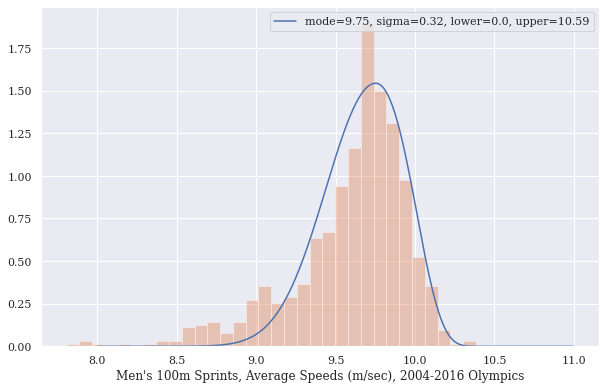

In [54]:
ydata = sprint_data[sprint_data.Gender == 'M']['speed']
sample_size = len(ydata)
shapes, popt, pcov = bounded_lognorm.fit(ydata, MLE=False, fit_cdf=False,
                                         flower=0)
shapes_rounded = shapes.round(2)
label = (    'mode=' + str(shapes_rounded[0]) +
          ', sigma=' + str(shapes_rounded[1]) +
          ', lower=' + str(shapes_rounded[2]) +
          ', upper=' + str(shapes_rounded[3]))
xdata = np.linspace(8, 11, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(ydata[ydata>7], kde=False, norm_hist=True)
plt.xlabel("Men's 100m Sprints, Average Speeds (m/sec), 2004-2016 Olympics")
plt.legend()
plt.show()

In [55]:
bpt = 100/popt[-1] 
bpt.round(2)

9.44

In [56]:
stdev = np.sqrt(np.diag(pcov))[-1]
conf_interval = np.array([bpt - 2 * stdev, bpt + 2 * stdev])
conf_interval.round(2)

array([9.18, 9.7 ])

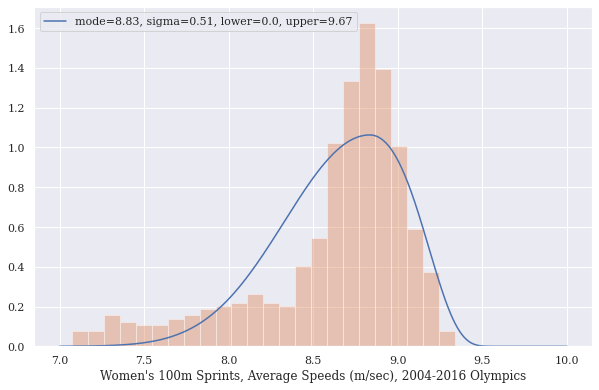

In [57]:
ydata = sprint_data[sprint_data.Gender == 'F']['speed']
sample_size = len(ydata)
shapes, popt, pcov = bounded_lognorm.fit(ydata, MLE=False, fit_cdf=True,
                                         fmode=ydata.mode()[0],
                                         flower=0)
shapes_rounded = shapes.round(2)
label = (    'mode=' + str(shapes_rounded[0]) +
          ', sigma=' + str(shapes_rounded[1]) +
          ', lower=' + str(shapes_rounded[2]) +
          ', upper=' + str(shapes_rounded[3]))
xdata = np.linspace(7, 10, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(ydata[ydata>7], kde=False, norm_hist=True)
plt.xlabel("Women's 100m Sprints, Average Speeds (m/sec), 2004-2016 Olympics")
plt.legend()
plt.show()

In [58]:
bpt = 100/popt[-1] 
bpt.round(2)

10.34

In [59]:
stdev = np.sqrt(np.diag(pcov))[-1]
conf_interval = np.array([bpt - 2 * stdev, bpt + 2 * stdev])
conf_interval.round(2)

array([10.26, 10.42])

But aren't we assuming that the upper bound, which is outside the range of the sample data, is nonetheless inherent in the data?

Here is an example of a random sample of 10,000 fictional runners, each with 10 qualities with values ranging from 0 to 1. The sum of the runners' qualities therefore can range from 0 to 10. The perfect runner is a 10 and the (perfectly) worst runner is a 0

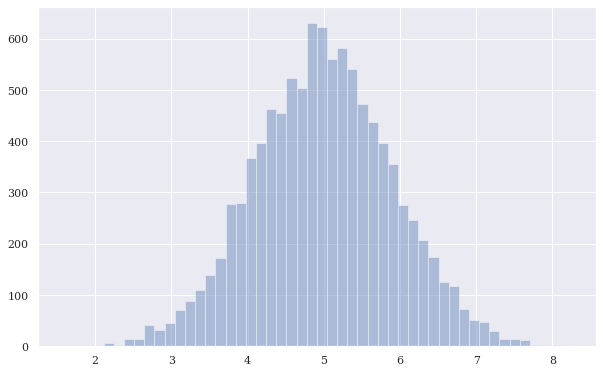

In [60]:
runners = np.random.random_sample(size=(10, 10000))
runner_sums = runners.sum(axis=0)
sns.distplot(runner_sums, kde=False)

Say we don't know the value sum of the perfect runner, but we do of the worst (0). Let's estimate the perfect runner.

In [61]:
shapes, popt, pcov = bounded_lognorm.fit(runner_sums, flower=0,
                                         fmode=np.median(runner_sums), 
                                         MLE=False, fit_cdf=True)
upper_estd = shapes[-1]
print("The best possible runner, estimated:", upper_estd.round(2))

The best possible runner, estimated: 10.09


In [62]:
stdev = np.sqrt(np.diag(pcov))[-1]
conf_interval = np.array([upper_estd - 2 * stdev, upper_estd + 2 * stdev])
print("with a ~95% confidence interval of", conf_interval.round(2))

with a ~95% confidence interval of [10.08 10.1 ]


These are much closer to the theoretically perfect runner (with value sum = 10) than the best from the sample.

In [63]:
print("The best runner in the sample:", max(runner_sums).round(2))

The best runner in the sample: 8.24


# scratch 1

In [64]:
tests = []
np.random.seed()
for i in range(100):
    runners = np.random.rand(10, 1000)
    runner_sums = runners.sum(axis=0)
    shapes, popt, pcov = bounded_lognorm.fit(runner_sums, 
                                             flower=0,
                                             fmode=np.median(runner_sums),
                                             MLE=False, fit_cdf=True)
    upper_estd = popt[-1]
    stdev = np.sqrt(np.diag(pcov)[-1])
    conf_interval = np.array([upper_estd - 2 * stdev, upper_estd + 2 * stdev])
    tests.append([upper_estd.round(2), conf_interval[0].round(2), conf_interval[1].round(2)])
a = np.array(tests)
np.mean(a, axis=0)

array([ 9.9946,  9.9611, 10.0283])

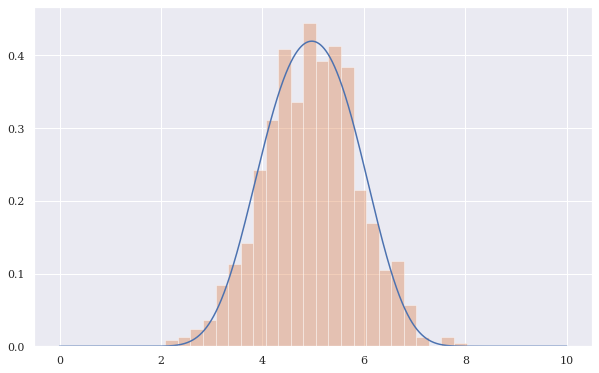

In [65]:
x = np.linspace(0,10,10000)
y = bounded_lognorm.pdf(x, *shapes)
sns.lineplot(x, y)
sns.distplot(runner_sums, kde=False, norm_hist=True)

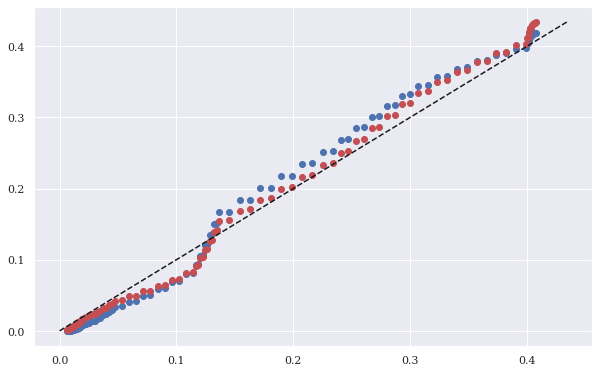

In [66]:
x = np.linspace(runner_sums.min(), runner_sums.max(), 100)

y = np.histogram(runner_sums, density=True)[0]
y_BLN = bounded_lognorm.pdf(x, *shapes)
y_N = norm.pdf(x,runner_sums.mean(),runner_sums.std())

qs = np.linspace(0, 1, 100)
qn = np.quantile(y, qs)
qn_BLN = np.quantile(y_BLN,  qs)
qn_N = np.quantile(y_N,  qs)

plt.plot(qn, qn_BLN, ls="", marker="o", color='b')
plt.plot(qn, qn_N, ls="", marker="o", color='r')

gmin = min(qn.min(), qn_BLN.min(), qn_N.min())
gmax = max(qn.max(), qn_BLN.max(), qn_N.max())

x_line = np.linspace(gmin, gmax)
plt.plot(x_line, x_line, color="k", ls="--")

plt.show()

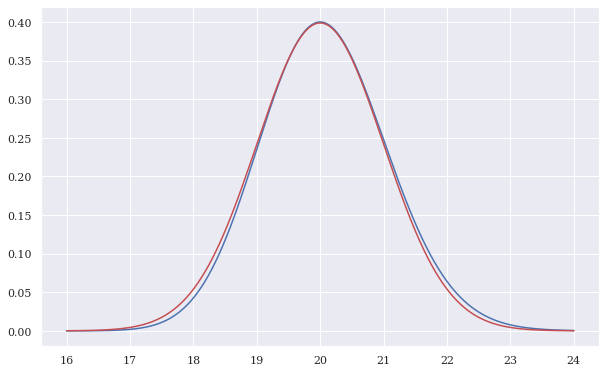

In [67]:
mode = 20
sigma = 1
mu_N, sigma_N = lognorm_params(mode, sigma)
x = np.linspace(mode - 4 * sigma, mode + 4 * sigma, 1000)
y = lognorm_pdf(x, mu_N, sigma_N)
y_N = norm.pdf(x, mode, sigma)
sns.lineplot(x, y, color='b')
sns.lineplot(x, y_N, color='r')

In [68]:
mu_N, sigma_N

(array([2.99821068]), array([0.0497836]))

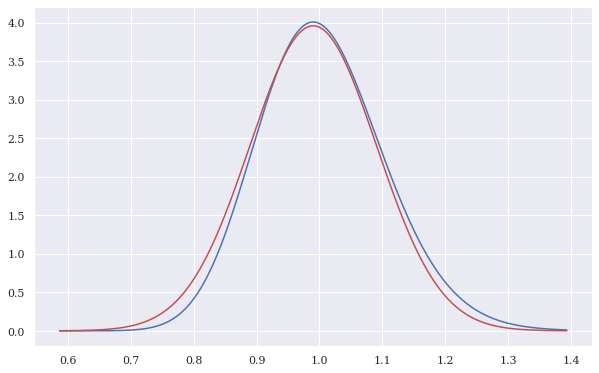

In [69]:
mu_N, sigma_N = 0, 0.1
mode = np.exp(mu_N - sigma_N**2)
sigma = ((np.exp(sigma_N**2) - 1) * np.exp(2 * mu_N + sigma_N**2))**0.5

x = np.linspace(mode - 4 * sigma, mode + 4 * sigma, 1000)

y = lognorm_pdf(x, mu_N, sigma_N)
y_N = norm.pdf(x, mode, sigma)
sns.lineplot(x, y, color='b')
sns.lineplot(x, y_N, color='r')

In [70]:
mode, sigma

(0.9900498337491681, 0.10075302944620396)

# scratch 2

In [71]:
shapes2 = 5, 10, -5, 20  # mode, sigma, lower, upper
bounded_lognorm.entropy(*shapes2)  # too slow?

array(2.7336542)